In [1]:
!nvidia-smi

Thu May 27 03:40:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P0    51W /  N/A |    530MiB /  8111MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
if not os.path.isdir('keras-retinanet'):
    !git clone https://github.com/fizyr/keras-retinanet.git

In [3]:
#!pip install --upgrade keras

In [4]:
%cd keras-retinanet
!ls

/home/skycam/sample_projs/fasterrcnn/RetinaNet_Fabric_Defect/keras-retinanet
 alldata.csv	       classes.csv	 maskdb		    setup.py
 annotations.csv       examples		 README.md	    snapshots
 build		       keras_retinanet	 requirements.txt   tests
'classes (copy).csv'   LICENSE		 setup.cfg	    xml2csv.py


In [5]:

!ls
if 1: #make this 1 and run only on very first time
    !pip install .
    !python setup.py build_ext --inplace
    !pip install gdown
    !pip install tensorflow

 alldata.csv	       classes.csv	 maskdb		    setup.py
 annotations.csv       examples		 README.md	    snapshots
 build		       keras_retinanet	 requirements.txt   tests
'classes (copy).csv'   LICENSE		 setup.cfg	    xml2csv.py
Processing /home/skycam/sample_projs/fasterrcnn/RetinaNet_Fabric_Defect/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=167023 sha256=d1530a7d6bde0495f884195cf206f14929ce27de23c8e3f9809fac39fa89c8f5
  Stored in directory: /home/skycam/.cache/pip/wheels/1b/15/ac/3f9d9a6f1a47a16650021447d7cb308be1531016363614

In [6]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
os.makedirs("snapshots", exist_ok=True)

In [8]:
#https://curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/
#https://colab.research.google.com/drive/1ldnii3sGJaUHPV6TWImykbeE_O-8VIIN#scrollTo=5DgiQ4FR0go6

In [9]:
os.makedirs("maskdb", exist_ok=True)

In [10]:
!python3 xml2csv.py

maskdb/train/c1r1e1n4_213.xml
xml to csv maskdb/train/c1r1e1n4_213.xml
maskdb/train/c1r1e1n3_197.xml
xml to csv maskdb/train/c1r1e1n3_197.xml
maskdb/train/c1r1e1n2_193.xml
xml to csv maskdb/train/c1r1e1n2_193.xml
maskdb/train/c1r1e1n1_179.xml
xml to csv maskdb/train/c1r1e1n1_179.xml
xml_df                       image_name  x_min  y_min  x_max  y_max class_name
0  maskdb/train/c1r1e1n4_213.tif    212    324    239    345       Hole
1  maskdb/train/c1r1e1n3_197.tif    160    358    185    380       Hole
2  maskdb/train/c1r1e1n2_193.tif    302    408    327    445       Hole
3  maskdb/train/c1r1e1n1_179.tif    583    376    605    397       Hole


In [11]:
df = pd.read_csv('alldata.csv')
df.head()

image_name  x_min  y_min  x_max  y_max class_name
0  maskdb/train/c1r1e1n4_213.tif    212    324    239    345       Hole
1  maskdb/train/c1r1e1n3_197.tif    160    358    185    380       Hole
2  maskdb/train/c1r1e1n2_193.tif    302    408    327    445       Hole
3  maskdb/train/c1r1e1n1_179.tif    583    376    605    397       Hole

In [12]:
df.iloc[0]

image_name    maskdb/train/c1r1e1n4_213.tif
x_min                                   212
y_min                                   324
x_max                                   239
y_max                                   345
class_name                             Hole
Name: 0, dtype: object

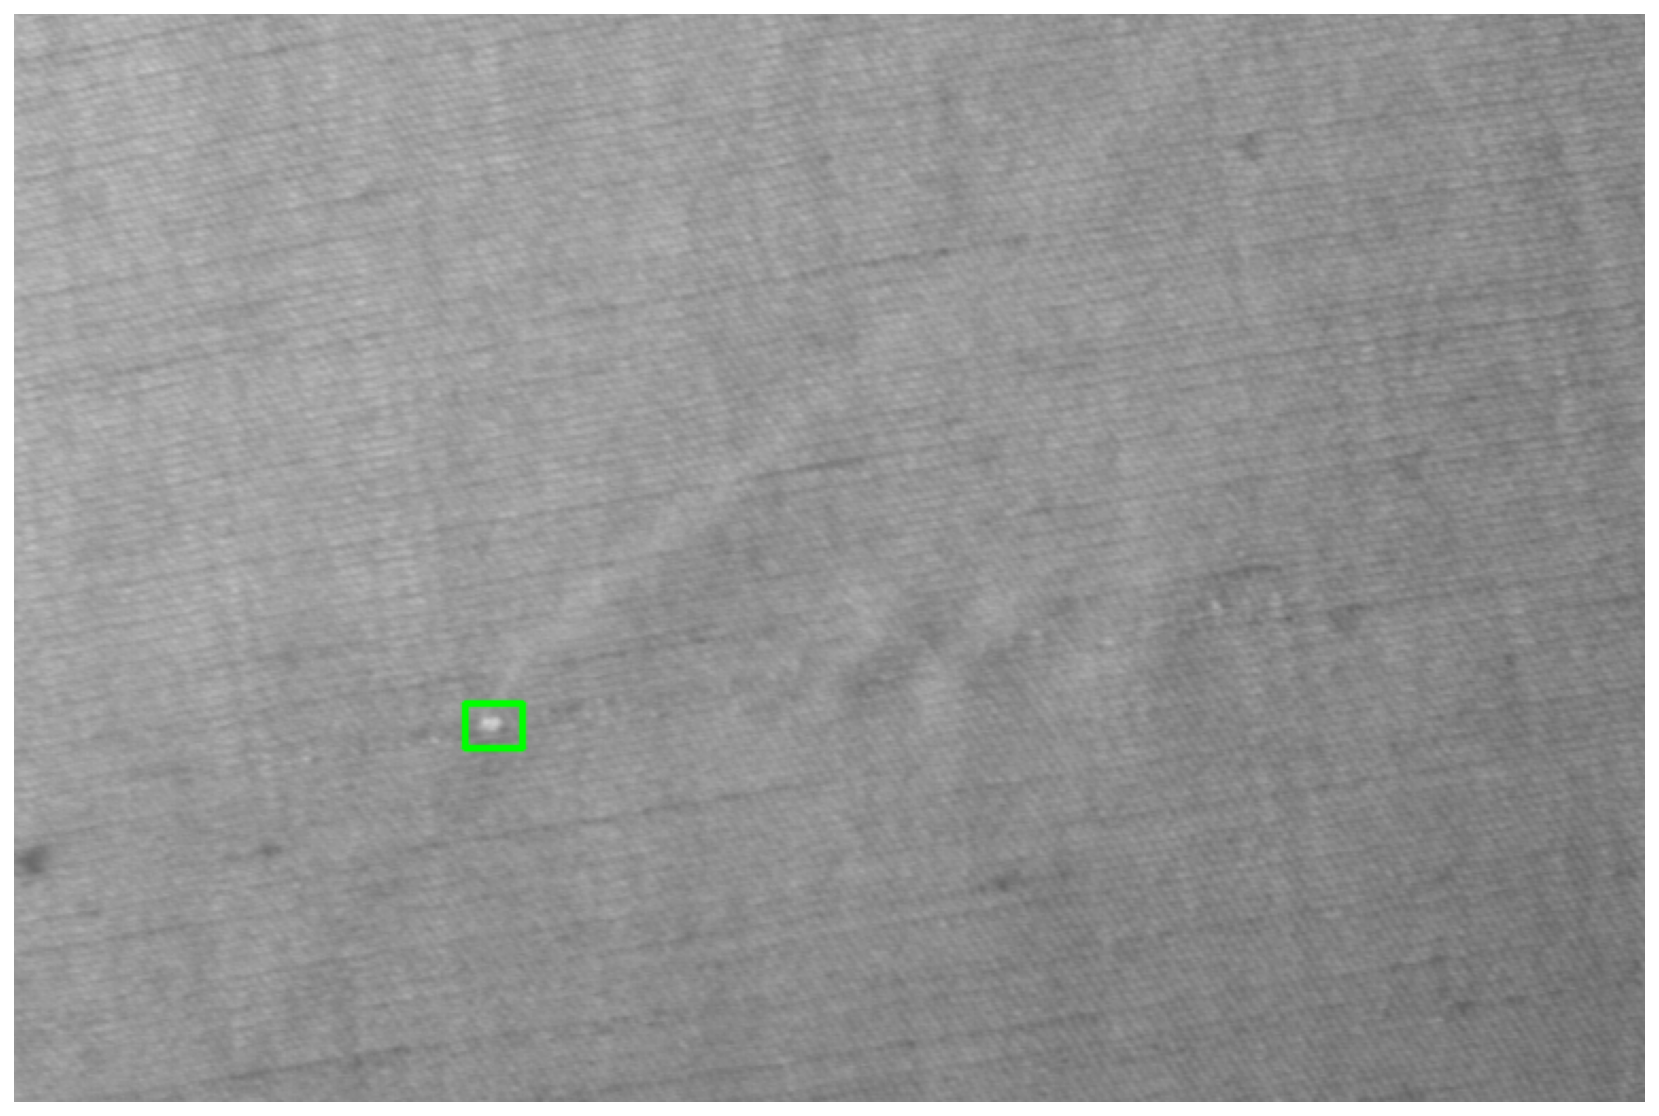

In [13]:
def show_image_objects(image_row):

    img_path = image_row.image_name
    box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
    ]

    image = cv2.imread(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_box(draw, box, color=(0, 255, 0))

    plt.axis('off')
    plt.imshow(draw)
    plt.show()
show_image_objects(df.iloc[0])

In [14]:
df

image_name  x_min  y_min  x_max  y_max class_name
0  maskdb/train/c1r1e1n4_213.tif    212    324    239    345       Hole
1  maskdb/train/c1r1e1n3_197.tif    160    358    185    380       Hole
2  maskdb/train/c1r1e1n2_193.tif    302    408    327    445       Hole
3  maskdb/train/c1r1e1n1_179.tif    583    376    605    397       Hole

In [15]:
os.path.join(os.getcwd() ,df.iloc[0].image_name)

'/home/skycam/sample_projs/fasterrcnn/RetinaNet_Fabric_Defect/keras-retinanet/maskdb/train/c1r1e1n4_213.tif'

In [16]:
#!ls
print(df.iloc[0])
img = cv2.imread(os.path.join(os.getcwd() ,df.iloc[0].image_name),1)

df.iloc[0].image_name
img.shape

image_name    maskdb/train/c1r1e1n4_213.tif
x_min                                   212
y_min                                   324
x_max                                   239
y_max                                   345
class_name                             Hole
Name: 0, dtype: object


(512, 768, 3)

In [17]:
!ls
df.iloc[0].image_name

 alldata.csv	       classes.csv	 maskdb		    setup.py
 annotations.csv       examples		 README.md	    snapshots
 build		       keras_retinanet	 requirements.txt   tests
'classes (copy).csv'   LICENSE		 setup.cfg	    xml2csv.py


'maskdb/train/c1r1e1n4_213.tif'

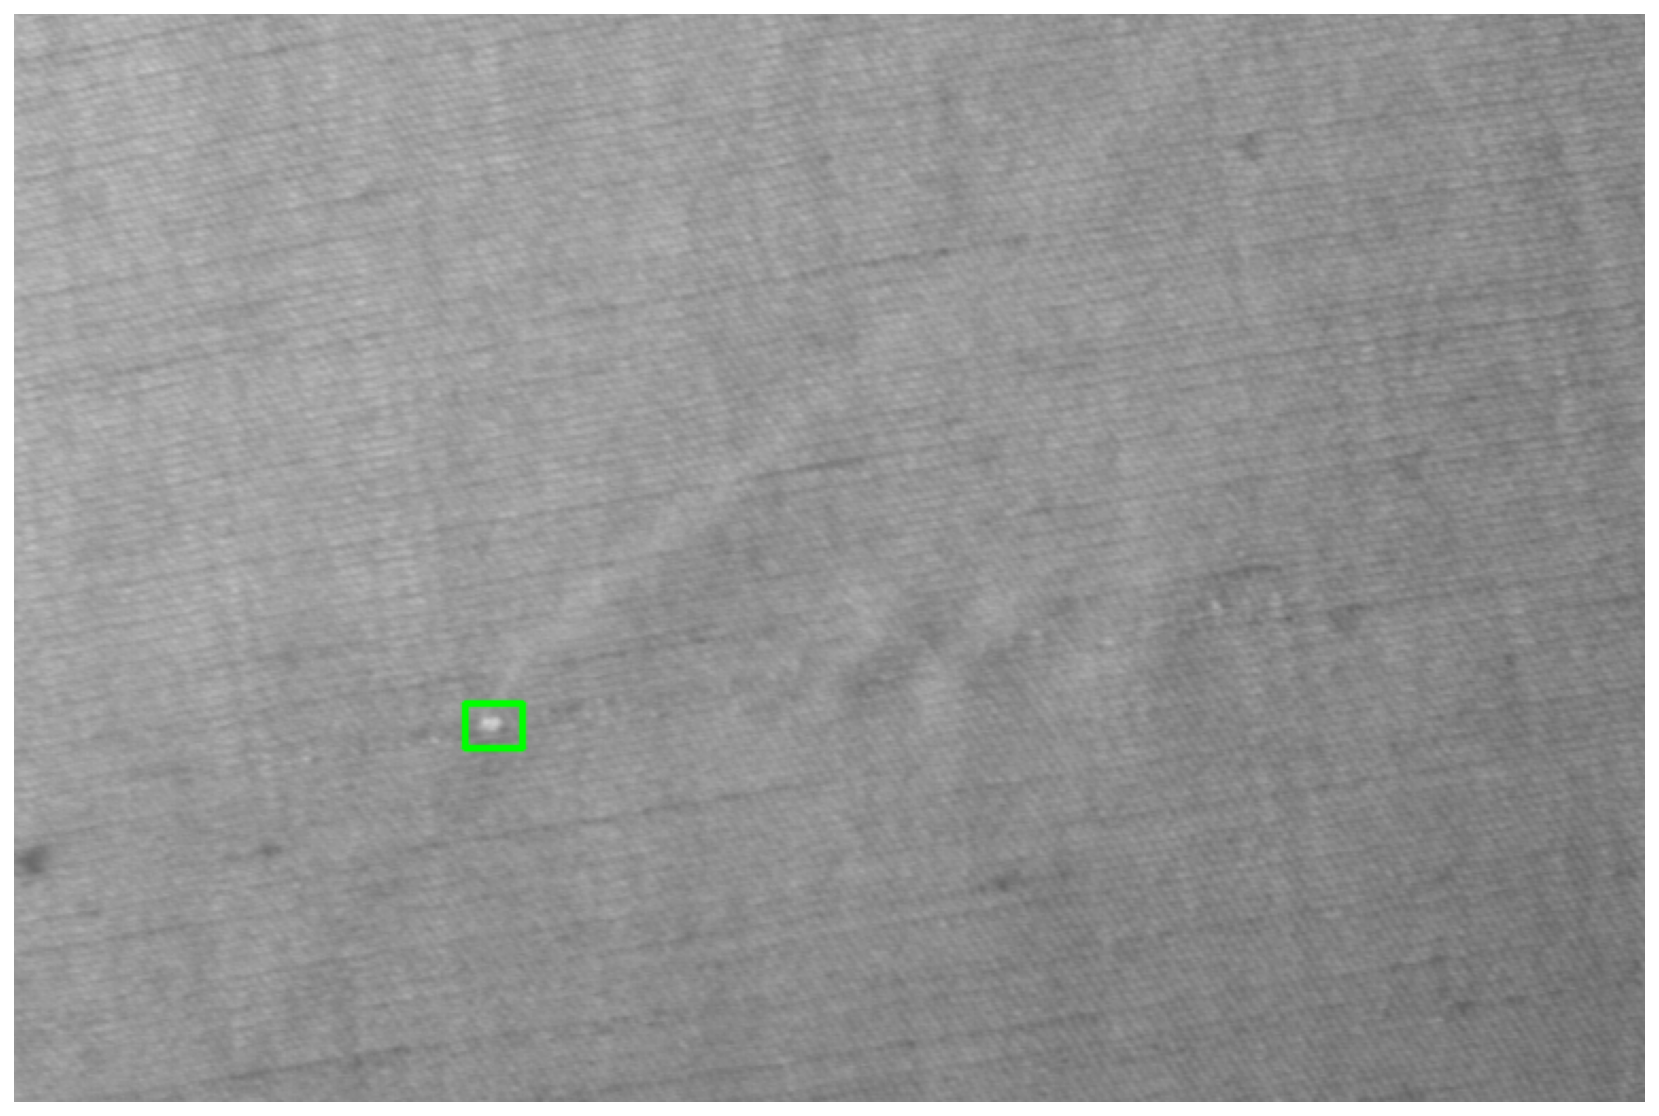

In [18]:
show_image_objects(df.iloc[0])

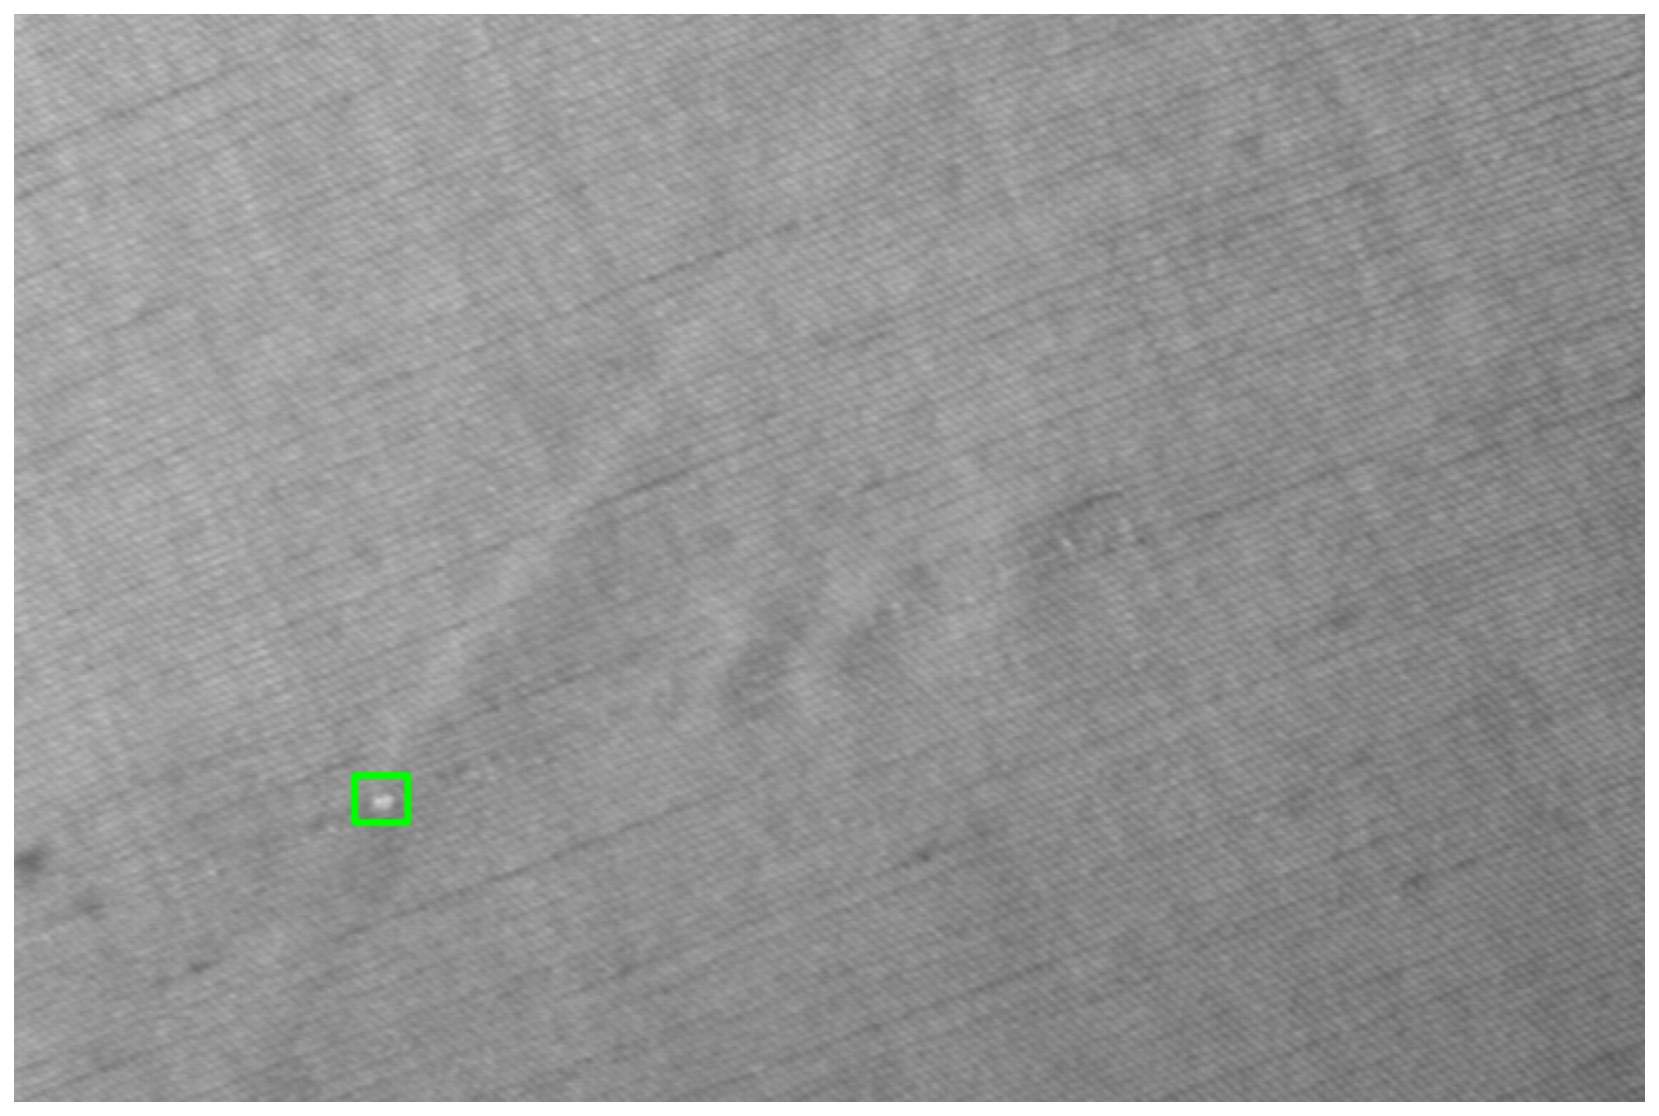

In [19]:
show_image_objects(df.iloc[1])

# Preprocessing

In [20]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [21]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [22]:
train_df

image_name  x_min  y_min  x_max  y_max class_name
3  maskdb/train/c1r1e1n1_179.tif    583    376    605    397       Hole
0  maskdb/train/c1r1e1n4_213.tif    212    324    239    345       Hole
2  maskdb/train/c1r1e1n2_193.tif    302    408    327    445       Hole

In [23]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [24]:
!head classes.csv

Stain,0
Hole,1
Line,2


In [25]:
!head annotations.csv

maskdb/train/c1r1e1n1_179.tif,583,376,605,397,Hole
maskdb/train/c1r1e1n4_213.tif,212,324,239,345,Hole
maskdb/train/c1r1e1n2_193.tif,302,408,327,445,Hole


# Training

In [26]:
if 1:
    PRETRAINED_MODEL = './snapshots/resnet50_csv_.h5'
    if not os.path.isfile(PRETRAINED_MODEL):
        PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
        if not os.path.isfile(PRETRAINED_MODEL):
            URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
            urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
            print('Downloaded pretrained model to ' + PRETRAINED_MODEL)
        

In [27]:
!pip3 install progressbar2

In [28]:
if 1:#make this one and run to train again
    !keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 4 --steps 10 --epochs 10 csv annotations.csv classes.csv

2021-05-27 03:40:24.180325: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Creating model, this may take a second...
2021-05-27 03:40:25.677513: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-27 03:40:25.678330: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-27 03:40:25.710489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-27 03:40:25.711150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.771GHz coreCount: 20 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 298.32GiB/s
2021-05-27 03:40:25.711194: I ten

2021-05-27 03:40:29.461608: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-05-27 03:40:29.479690: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz
Epoch 1/10
2021-05-27 03:40:34.524861: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-05-27 03:40:35.446548: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-05-27 03:40:35.669264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
10/10 [==============================] - 9s 752us/step - loss: 3.7634 - regression_loss: 2.6130 - classification_loss: 1.1505

Epoch 00001: loss improved from inf to 3.76344, saving model to ./snapshots/resnet50_csv_.h5


# Loading the trained model

In [29]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_.h5


In [30]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_.h5


# Predictions

In [31]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [32]:
THRES_SCORE = 0.2

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score > THRES_SCORE:
        #break

        color = label_color(label)
        #print('label',label)
        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(image, b, caption)

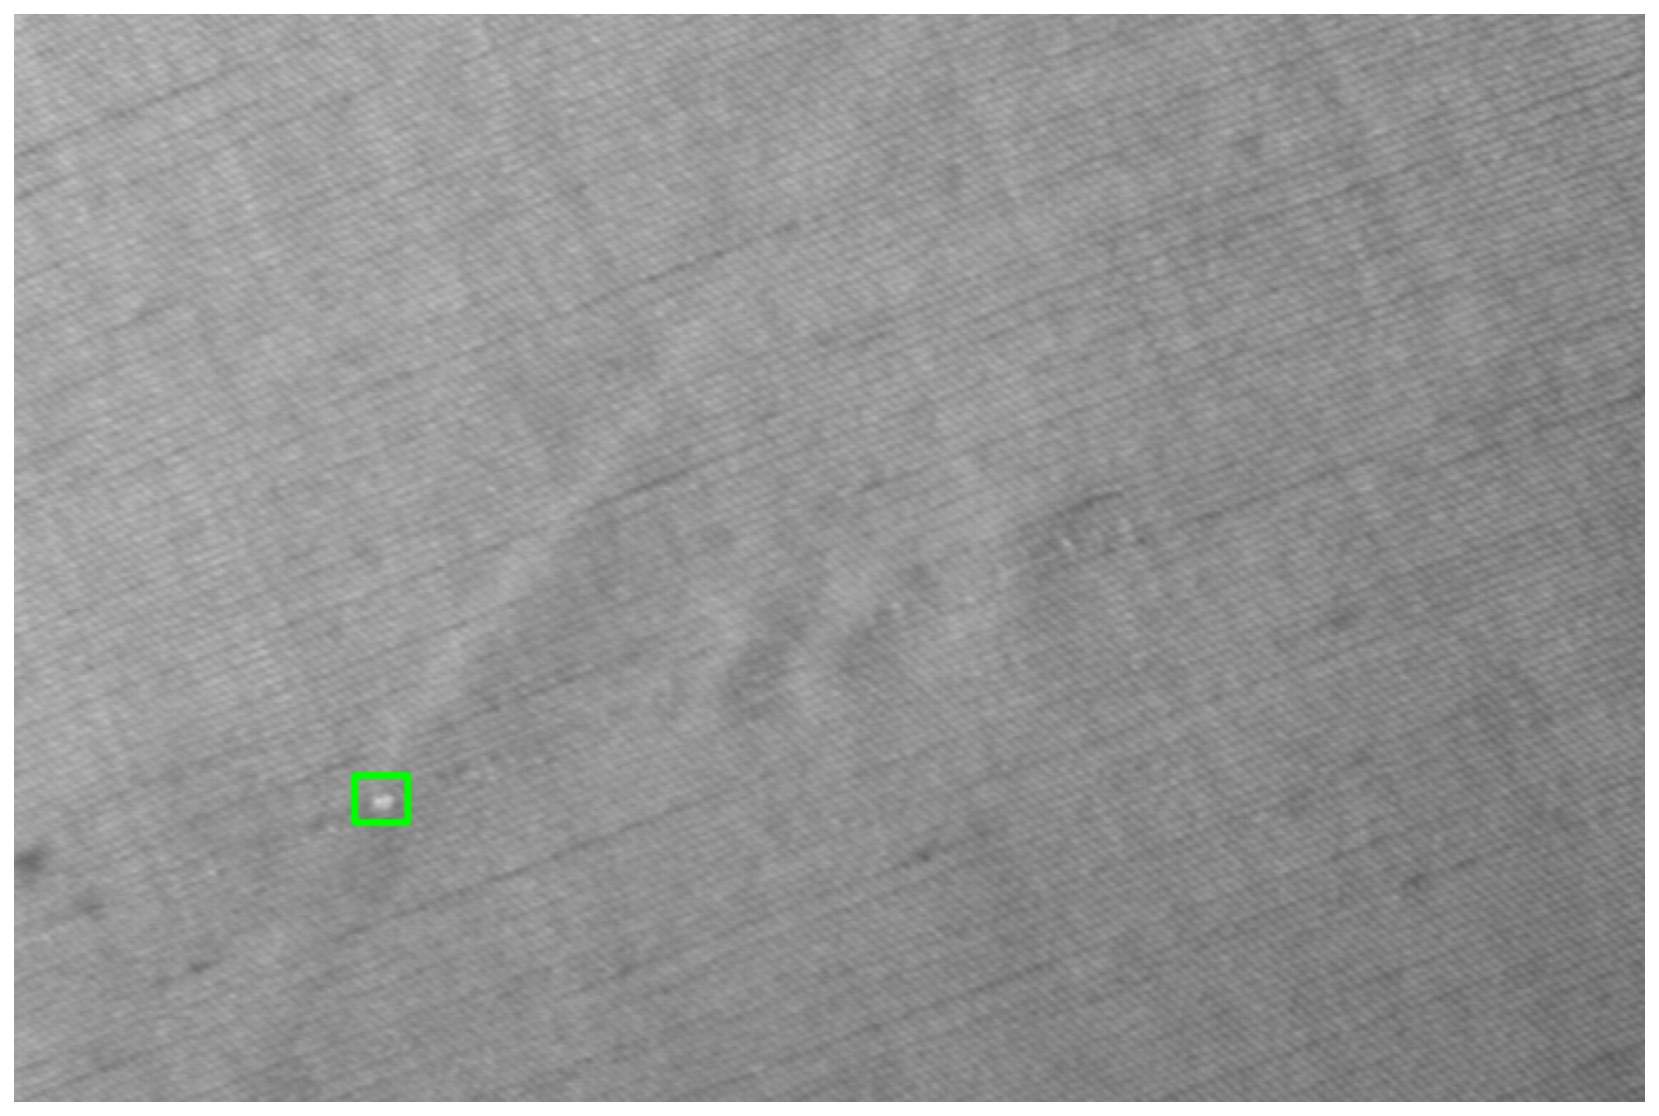

In [33]:
def show_detected_objects(image_row):
    img_path = image_row.image_name

    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)
    #import pdb;pdb.set_trace()

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
    ]
    draw_box(draw, true_box, color=(0, 255, 0))

    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.show()
show_detected_objects(test_df.iloc[0])

In [34]:
test_df.head(n=10)

image_name  x_min  y_min  x_max  y_max class_name
1  maskdb/train/c1r1e1n3_197.tif    160    358    185    380       Hole

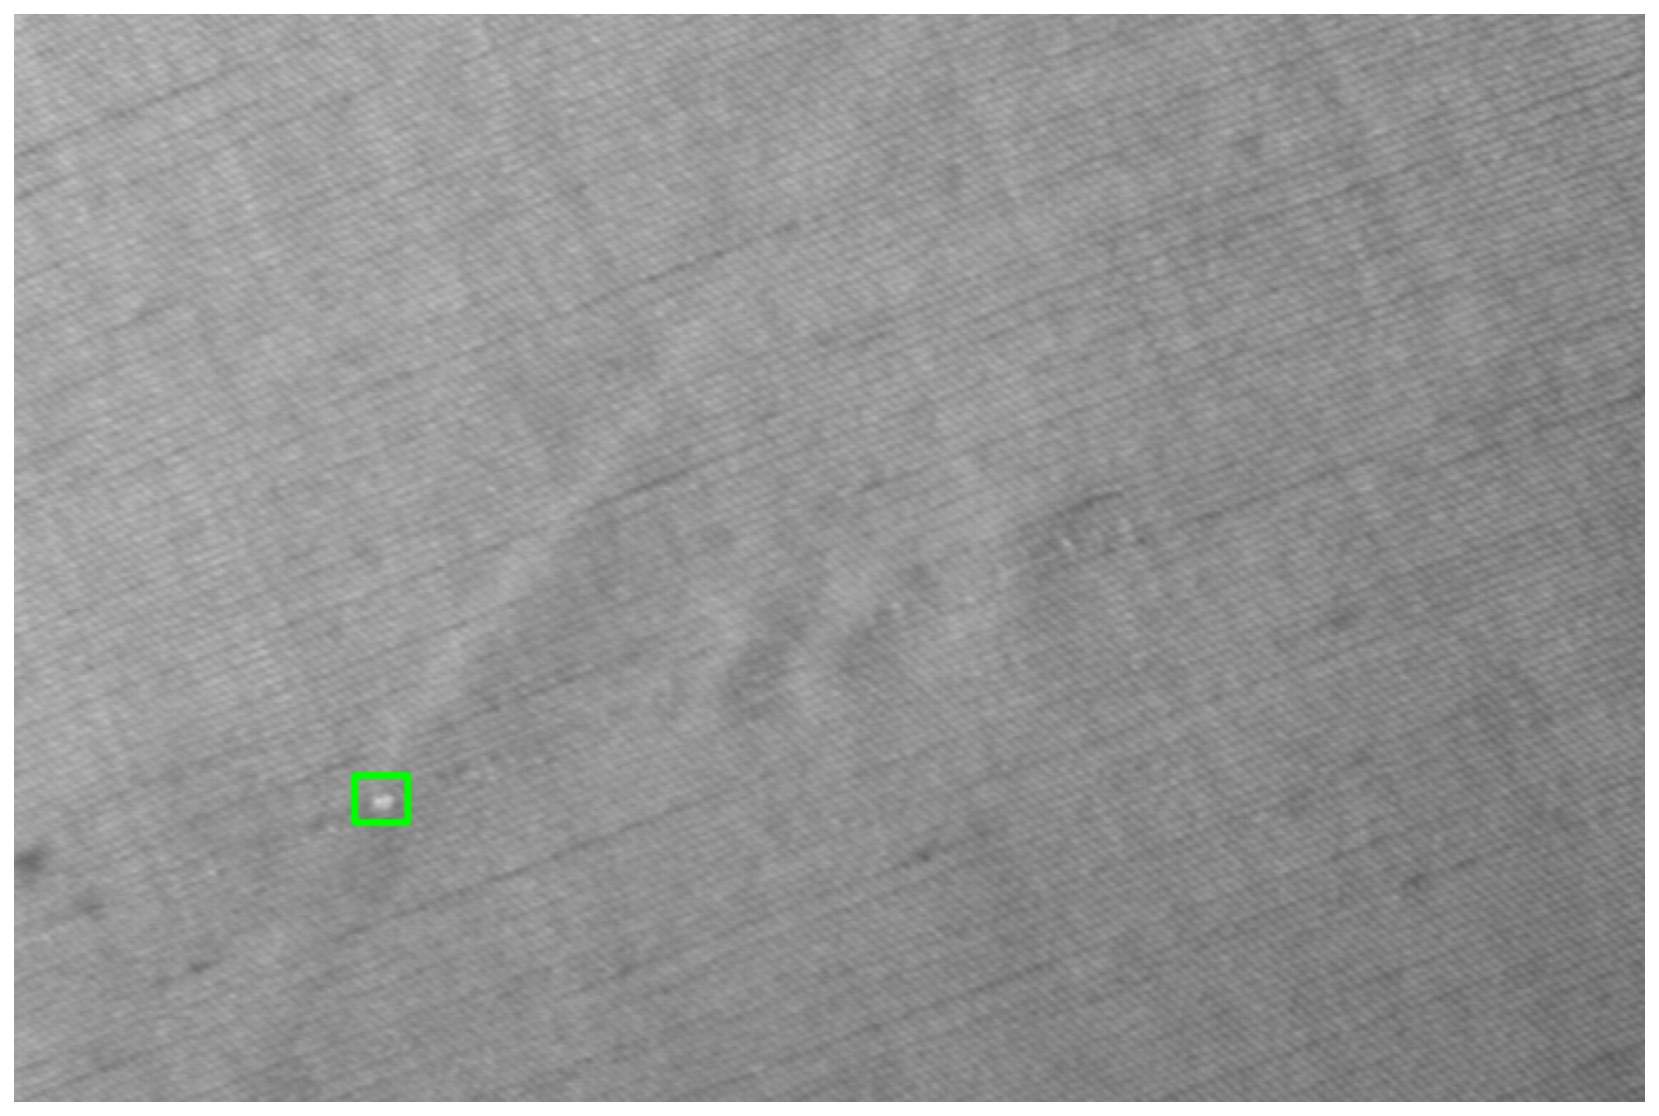

In [35]:
show_detected_objects(test_df.iloc[0])

In [36]:
#show_detected_objects(test_df.iloc[1])

In [37]:
#show_detected_objects(test_df.iloc[2])